In [1]:
# Helper libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')

In [2]:
from sklearn.decomposition import PCA

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
tf_gpus = [x for x in device_lib.list_local_devices() if x.device_type == 'GPU']


In [6]:
import os
import sys

In [7]:
import boto3
client = boto3.Session(profile_name='personal').client("dynamodb")
from jmpy.dynamodb import DynamoDB
dynamodb = DynamoDB(client=client)

In [8]:
def stock_prices(symbol, interpolate=True):
    query = dict(table='Price', filter='symbol = :sym', values={":sym":symbol})
    df = pd.DataFrame(dynamodb.query(**query))
    df.date = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    df.set_index('date',inplace=True)
    return df

def interpolate_df(df):
    for col in df:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_reindexed = df.reindex(
        pd.date_range(
            start=df.index.min(),
            end=df.index.max(),
            freq='1D'
        )
    ) 
    df = df_reindexed.interpolate(method='linear') 
    return df


In [9]:
def get_windows(series,wsize=30):
    one_day = datetime.timedelta(days=1)
    
    start = series.index.min()
    end = series.index.max()
    
    to_str = lambda x: x.isoformat()
    ws,we = start, start+datetime.timedelta(days=wsize-1)
    windows = list()
    while we <= end:
        windows.append(series[ws:we])
        we += one_day
        ws += one_day
    return windows

#### Confirm TensorFlow Config

In [10]:
print(tf.__version__)
print(tf_gpus)

1.12.0
[]


In [11]:
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12027926636621928085]

#### Get some data

In [12]:
test_sym = 'MSFT'
test_df = stock_prices(test_sym)

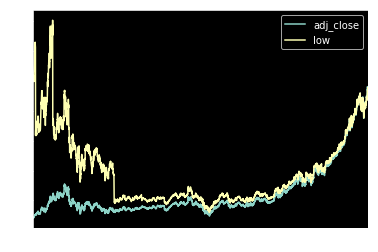

In [13]:
test_df = interpolate_df(test_df)
test_df[['adj_close','low']].plot()

In [14]:
test_df.head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,10.679600,131.13,0.0,131.50,129.500000,129.63,1.0,NaN,4968500.0
1998-01-03,10.659267,130.88,0.0,132.21,128.956667,130.17,1.0,NaN,6661400.0
1998-01-04,10.638933,130.63,0.0,132.92,128.413333,130.71,1.0,NaN,8354300.0
1998-01-05,10.618600,130.38,0.0,133.63,127.870000,131.25,1.0,NaN,10047200.0
1998-01-06,10.679600,131.13,0.0,133.00,129.250000,129.75,1.0,NaN,8479300.0


In [15]:
test_df['delta'] = test_df.adj_close.pct_change()

In [16]:
test_df.head()

,adj_close,close,dividend,high,low,open,split,symbol,volume,delta
1998-01-02,10.679600,131.13,0.0,131.50,129.500000,129.63,1.0,NaN,4968500.0,NaN
1998-01-03,10.659267,130.88,0.0,132.21,128.956667,130.17,1.0,NaN,6661400.0,-0.001904
1998-01-04,10.638933,130.63,0.0,132.92,128.413333,130.71,1.0,NaN,8354300.0,-0.001908
1998-01-05,10.618600,130.38,0.0,133.63,127.870000,131.25,1.0,NaN,10047200.0,-0.001911
1998-01-06,10.679600,131.13,0.0,133.00,129.250000,129.75,1.0,NaN,8479300.0,0.005745


In [17]:
ft = test_df.adj_close.index.min().isoformat()

In [18]:
for k in test_df.adj_close[ft:]:
    print(k)
    break

10.6796


In [19]:
t = get_windows(test_df.adj_close)

In [21]:
mat = np.array(t)

In [22]:
mat.shape

(7735, 30)